In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import pickle
from CharRNN import RNN
import chars2vec
from transformers import BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [2]:
############ Hyperparameters ############
hidden_size = 512   # size of hidden state
num_layers = 3      # num of layers in LSTM layer stack

load_path = "./preTrained/CharRNN_rockyou.pth"
data_path = "./data/flitered_rockyou.txt"
#########################################

# load the text file
data = open(data_path, 'r').read()
chars = sorted(list(set(data)-set('\n')))
data_size, vocab_size = len(data), len(chars)
print("----------------------------------------")
print("Data has {} characters, {} unique".format(data_size, vocab_size))
print("----------------------------------------")

# char to index and idex to char maps
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# create and load model instance
rnn = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
rnn.load_state_dict(torch.load(load_path))
print("Model loaded successfully !!")

c2v_model = chars2vec.load_model('eng_50')

----------------------------------------
Data has 128399604 characters, 62 unique
----------------------------------------
Model loaded successfully !!


In [11]:
def generate_n_honey_password(true_password, num_honey_password=50, choose_n=10):
    generate_honey_password = 0
    new_passwords = []
    
    TestData = true_password
    new_passwords.append(TestData)

    token_list = tokenizer.tokenize(TestData)
    print(token_list)

    if len(token_list)>3:
        keep_len = len(TestData)-len(token_list[-1])+2-len(token_list[-2])+2-len(token_list[-3])+2
    elif len(token_list)>1:
        keep_len = len(token_list[0])
    elif len(token_list)==1:
        keep_len = len(TestData)-3

    op_seq_len = len(TestData) - keep_len
    new_password_const = TestData[:keep_len]

    TestData = list(TestData)
    for i, ch in enumerate(TestData):
        TestData[i] = char_to_ix[ch]

    TestData = torch.tensor(TestData).to(device)
    TestData = torch.unsqueeze(TestData, dim=1)

    while(generate_honey_password<num_honey_password):
        data_ptr = 0
        hidden_state = None
        input_seq = TestData[0:keep_len]
        _, hidden_state = rnn(input_seq, hidden_state)
        input_seq = TestData[keep_len-1:keep_len]
        new_password = new_password_const
        while True:
            # forward pass
            output, hidden_state = rnn(input_seq, hidden_state)
            # construct categorical distribution and sample a character
            output = F.softmax(torch.squeeze(output), dim=0)
            dist = Categorical(output)
            index = dist.sample().item()
            new_password += ix_to_char[index]
            # next input is current output
            input_seq[0][0] = index
            data_ptr += 1
            if data_ptr >= op_seq_len:
                break
        if new_password in set(new_passwords):
            pass
        else:
            generate_honey_password += 1
#             print(new_password)
            new_passwords.append(new_password)
#             print("----------------------------------------")

    # Create word embeddings
    word_embeddings = c2v_model.vectorize_words(new_passwords)
#     print(word_embeddings.shape)
    distance = np.sum((word_embeddings[1:,:] - word_embeddings[0,:])**2,axis=1)
    
    return_passwords = []
    for i in range(choose_n):
#         print(new_passwords[np.argsort(distance)[i]+1])
        return_passwords.append(new_passwords[np.argsort(distance)[i]+1])
    
    return return_passwords

In [14]:
generate_n_honey_password('Language', choose_n=50)

['Language']
2/2 [==============================] - 0s 9ms/step


['Langu993',
 'Langu639',
 'Langu196',
 'Langu912',
 'Langu999',
 'Langu123',
 'Langu743',
 'Langu431',
 'Langu411',
 'Langu96V',
 'Langu601',
 'Langu351',
 'Langu907',
 'Langu154',
 'Langu950',
 'Langu122',
 'Langu790',
 'LanguJ08',
 'Langu076',
 'Langu738',
 'Langunea',
 'LanguADA',
 'Langu378',
 'Langu427',
 'Langu42a',
 'Langu320',
 'Langu742',
 'Langu448',
 'Langu9cb',
 'Langu680',
 'Langu578',
 'Langua07',
 'Langu040',
 'Langu009',
 'Langura1',
 'Langu078',
 'Langu777',
 'Langu877',
 'Langu025',
 'Langu77k',
 'LanguELC',
 'LanguP64',
 'Languy23',
 'Langud02',
 'Langunga',
 'LanguURN',
 'LanguU81',
 'Langu75O',
 'Langubin',
 'Langutt2']

In [15]:
import chars2vec
import sklearn.decomposition
import matplotlib.pyplot as plt


# Load Inutition Engineering pretrained model
# Models names: 'eng_50', 'eng_100', 'eng_150', 'eng_200', 'eng_300'
c2v_model = chars2vec.load_model('eng_50')

# words = ['Natural', 'Language', 'Understanding',
#          'Naturael', 'Longuge', 'Updderctundjing',
#          'Motural', 'Lamnguoge', 'Understaating',
#          'Naturrow', 'Laguage', 'Unddertandink',
#          'Nattural', 'Languagge', 'Umderstoneding']

words = ['AliceBobo', 'HoneyNLP', 'Language',
         'AliceBoff', 'Honeymmm', 'Langunea',
         'AliceTass', 'Honey070', 'Langura1',
         'Alicefeta', 'Honey123', 'Langunga',
         'Alicelome', 'HoneyNLL', 'Langubin']

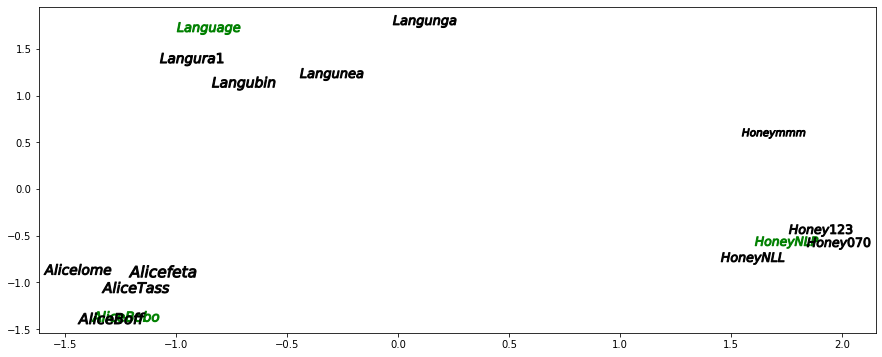

In [19]:
# Create word embeddings
word_embeddings = c2v_model.vectorize_words(words)

# Project embeddings on plane using the PCA
projection_2d = sklearn.decomposition.PCA(n_components=2).fit_transform(word_embeddings)

# Draw words on plane
f = plt.figure(figsize=(15, 6))

for j in range(len(projection_2d)):
    plt.scatter(projection_2d[j, 0], projection_2d[j, 1],
                marker=('$' + words[j] + '$'),
                s=500 * len(words[j]), label=j,
                facecolors='green' if words[j]
                            in ['AliceBobo', 'HoneyNLP', 'Language'] else 'black')
plt.savefig('chars2vec.eps',dpi=1000,format='eps')
plt.show()

In [ ]:
with open("./data/test_rockyou_typo.txt",'w') as file:
    f = open("./data/test_rockyou_true_password.txt")
    line = f.readline()
    file.write(line[:-1]+" ")
    while line:
        honey_passwords = generate_n_honey_password(line[:-1])
        for p in honey_passwords:
            file.write(p+" ")
        file.write("\n")
#         print(line[:-1])
        line = f.readline()
    f.close()

2/2 [==============================] - 0s 2ms/step


In [28]:
char_list = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z', \
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z', \
             '0','1','2','3','4','5','6','7','8','9']
count_char = np.zeros(26+26+10)

In [20]:
raw_passwords = []
f = open("./data/flitered_rockyou.txt")
line = f.readline()
while line:
    raw_passwords.append(line[:-1])
    line = f.readline()
f.close()

In [21]:
len(raw_passwords)

13326232

In [30]:
for p in raw_passwords:
    for c in p:
        count_char[char_list.index(c)] += 1

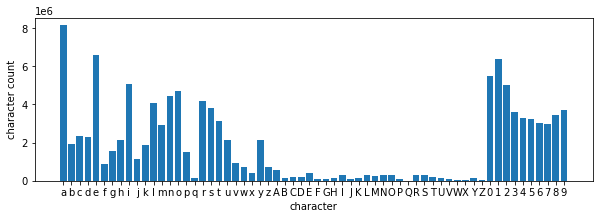

In [39]:
plt.figure(figsize=((10,3)))
plt.xlabel('character')
plt.ylabel('character count')
plt.bar(char_list, count_char)
plt.savefig('count.eps',dpi=1000,format='eps',bbox_inches="tight")

In [27]:
char_list.index('c')

2

In [148]:
test_idx = np.random.randint(low=0, high=len(raw_passwords), size=100)

In [149]:
with open("./data/test_rockyou_true_password.txt",'w') as f:
    for i in range(100):
        f.write(raw_passwords[test_idx[i]]+"\n")